In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss
from scipy.stats import chi2_contingency
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
from sklearn.ensemble import RandomForestClassifier
#!pip install pycaret
from pycaret.classification import *
from pycaret.regression import *

#### Importing the data

In [4]:
data=pd.read_csv("data/FannieAcq2000-19FMac30-sample2pt5.csv")
data.head()

,Unnamed: 0,loanIdentifier,origChannel,sellerName,origIntRate,origUPB,origDate,firstPmtDate,origLTV,origCLTV,...,pMIperct,mortInsType,bestCreditScore,worstCreditScore,avgCreditScore,fmacRate,fredRate,rateDiff,rateDiffPct,rank
0,5353740,832231376476,3,"GMAC MORTGAGE, LLC",5.875,242000,2007-01-01,2007-03-01,62.0,62.0,...,0.0,0.0,667.0,667.0,667.0,6.18,4.71,-0.305,-0.049353,3.0
1,4612284,877425485629,1,FIRST TENNESSEE BANK NATIONAL ASSOCIATION,4.875,168000,2005-03-01,2005-05-01,39.0,39.0,...,0.0,0.0,797.0,797.0,797.0,5.69,4.38,-0.815,-0.143234,2.0
2,7765258,191286475874,2,OTHER,4.375,556000,2011-11-01,2012-01-01,79.0,79.0,...,0.0,0.0,801.0,747.0,774.0,4.10,2.01,0.275,0.067073,3.0
3,4801103,788814542461,2,"BANK OF AMERICA, N.A.",6.500,112000,2005-08-01,2005-10-01,78.0,78.0,...,0.0,0.0,631.0,631.0,631.0,5.77,4.32,0.730,0.126516,4.0
4,3475269,173368078702,3,"IRWIN MORTGAGE, CORPORATION",5.250,220000,2003-08-01,2003-10-01,73.0,73.0,...,0.0,0.0,767.0,642.0,704.5,6.14,4.44,-0.890,-0.144951,2.0


In [5]:
data.rename(columns={'Unnamed: 0':'namedCol'}, inplace=True )

In [6]:
data.shape

(261615, 26)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 261615 entries, 0 to 261614
Data columns (total 26 columns):
namedCol            261615 non-null int64
loanIdentifier      261615 non-null int64
origChannel         261615 non-null int64
sellerName          261615 non-null object
origIntRate         261615 non-null float64
origUPB             261615 non-null int64
origDate            261615 non-null object
firstPmtDate        261615 non-null object
origLTV             261615 non-null float64
origCLTV            261615 non-null float64
numBorrowers        261615 non-null float64
origDebtIncRatio    261615 non-null float64
borrCreditScore     261615 non-null float64
loanPurp            261615 non-null int64
propState           261615 non-null object
zipCode             261615 non-null int64
pMIperct            261615 non-null float64
mortInsType         261615 non-null float64
bestCreditScore     261615 non-null float64
worstCreditScore    261615 non-null float64
avgCreditScore      26161

In [8]:
# # Create categories out of loan purpose that can be fed into ML models: 
# data['loanPurpCat'] = data['loanPurp'].replace(['C','R'],[0,1])
# data['loanPurpCat'].unique()

In [9]:
sellerNames = data['sellerName'].unique()
statesList = data['propState'].unique()

In [10]:
# Make copy of the column to map from strings to integers
data['bankNumber'] = data['sellerName']
# Coerce the new column to category type
data['bankNumber'] = data['bankNumber'].astype('category')
# Convert the new column to integers for each unique string value
data['bankNumber'] = data['bankNumber'].cat.codes
# Capture the mapping to a dictionary
sellerNameMap = pd.Series(data.sellerName.values,index=data.bankNumber).to_dict()
# Drop original column leaving only the integer column for ML purposes
data.drop(columns=['sellerName'],inplace=True)
print(sorted(sellerNameMap.items()))

[(0, 'ALLY BANK'), (1, 'AMERIHOME MORTGAGE COMPANY, LLC'), (2, 'AMERISAVE MORTGAGE CORPORATION'), (3, 'AMTRUST BANK'), (4, 'BANK OF AMERICA, N.A.'), (5, 'BISHOPS GATE RESIDENTIAL MORTGAGE TRUST'), (6, 'CALIBER HOME LOANS, INC.'), (7, 'CAPITAL ONE, NATIONAL ASSOCIATION'), (8, 'CASHCALL, INC.'), (9, 'CHASE HOME FINANCE'), (10, 'CHASE HOME FINANCE (CIE 1)'), (11, 'CHASE HOME FINANCE FRANKLIN AMERICAN MORTGAGE COMPANY'), (12, 'CHASE HOME FINANCE, LLC'), (13, 'CHICAGO MORTGAGE SOLUTIONS DBA INTERBANK MORTGAGE COMPANY'), (14, 'CHICAGO MORTGAGE SOLUTIONS DBA INTERFIRST MORTGAGE COMPANY'), (15, 'CITIMORTGAGE, INC.'), (16, 'CMG MORTGAGE, INC'), (17, 'DITECH FINANCIAL LLC'), (18, 'DOWNEY SAVINGS AND LOAN ASSOCIATION, F.A.'), (19, 'EAGLE HOME MORTGAGE, LLC'), (20, 'FAIRWAY INDEPENDENT MORTGAGE CORPORATION'), (21, 'FDIC, RECEIVER, INDYMAC FEDERAL BANK FSB'), (22, 'FEDERAL HOME LOAN BANK OF CHICAGO'), (23, 'FIFTH THIRD BANK'), (24, 'FINANCE OF AMERICA MORTGAGE LLC'), (25, 'FIRST TENNESSEE BANK NATI

In [11]:
# Make copy of the column to map from strings to integers
data['stateNumber'] = data['propState']
# Coerce the new column to category type
data['stateNumber'] = data['stateNumber'].astype('category')
# Convert the new column to integers for each unique string value
data['stateNumber'] = data['stateNumber'].cat.codes
# Capture the mapping to a dictionary
statePropMap = pd.Series(data.propState.values,index=data.stateNumber).to_dict()
# Drop original column leaving only the integer column for ML purposes
data.drop(columns=['propState'],inplace=True)
print(sorted(statePropMap.items()))

[(0, 'AK'), (1, 'AL'), (2, 'AR'), (3, 'AZ'), (4, 'CA'), (5, 'CO'), (6, 'CT'), (7, 'DC'), (8, 'DE'), (9, 'FL'), (10, 'GA'), (11, 'GU'), (12, 'HI'), (13, 'IA'), (14, 'ID'), (15, 'IL'), (16, 'IN'), (17, 'KS'), (18, 'KY'), (19, 'LA'), (20, 'MA'), (21, 'MD'), (22, 'ME'), (23, 'MI'), (24, 'MN'), (25, 'MO'), (26, 'MS'), (27, 'MT'), (28, 'NC'), (29, 'ND'), (30, 'NE'), (31, 'NH'), (32, 'NJ'), (33, 'NM'), (34, 'NV'), (35, 'NY'), (36, 'OH'), (37, 'OK'), (38, 'OR'), (39, 'PA'), (40, 'PR'), (41, 'RI'), (42, 'SC'), (43, 'SD'), (44, 'TN'), (45, 'TX'), (46, 'UT'), (47, 'VA'), (48, 'VI'), (49, 'VT'), (50, 'WA'), (51, 'WI'), (52, 'WV'), (53, 'WY')]


In [12]:
#Checking for missing values
data.isnull().sum()

namedCol            0
loanIdentifier      0
origChannel         0
origIntRate         0
origUPB             0
origDate            0
firstPmtDate        0
origLTV             0
origCLTV            0
numBorrowers        0
origDebtIncRatio    0
borrCreditScore     0
loanPurp            0
zipCode             0
pMIperct            0
mortInsType         0
bestCreditScore     0
worstCreditScore    0
avgCreditScore      0
fmacRate            0
fredRate            0
rateDiff            0
rateDiffPct         0
rank                0
bankNumber          0
stateNumber         0
dtype: int64

In [13]:
#Checking datatypes of individual feature
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 261615 entries, 0 to 261614
Data columns (total 26 columns):
namedCol            261615 non-null int64
loanIdentifier      261615 non-null int64
origChannel         261615 non-null int64
origIntRate         261615 non-null float64
origUPB             261615 non-null int64
origDate            261615 non-null object
firstPmtDate        261615 non-null object
origLTV             261615 non-null float64
origCLTV            261615 non-null float64
numBorrowers        261615 non-null float64
origDebtIncRatio    261615 non-null float64
borrCreditScore     261615 non-null float64
loanPurp            261615 non-null int64
zipCode             261615 non-null int64
pMIperct            261615 non-null float64
mortInsType         261615 non-null float64
bestCreditScore     261615 non-null float64
worstCreditScore    261615 non-null float64
avgCreditScore      261615 non-null float64
fmacRate            261615 non-null float64
fredRate            261

In [14]:
#Dropping columns we don't want
data.drop(['loanIdentifier','namedCol', 'firstPmtDate', 'bestCreditScore', 'worstCreditScore', 'rateDiff',
           'borrCreditScore'],1,inplace=True)

In [15]:
data.head()

,origChannel,origIntRate,origUPB,origDate,origLTV,origCLTV,numBorrowers,origDebtIncRatio,loanPurp,zipCode,pMIperct,mortInsType,avgCreditScore,fmacRate,fredRate,rateDiffPct,rank,bankNumber,stateNumber
0,3,5.875,242000,2007-01-01,62.0,62.0,1.0,42.0,1,29,0.0,0.0,667.0,6.18,4.71,-0.049353,3.0,32,41
1,1,4.875,168000,2005-03-01,39.0,39.0,1.0,21.0,2,967,0.0,0.0,797.0,5.69,4.38,-0.143234,2.0,25,12
2,2,4.375,556000,2011-11-01,79.0,79.0,2.0,30.0,2,946,0.0,0.0,774.0,4.10,2.01,0.067073,3.0,54,4
3,2,6.500,112000,2005-08-01,78.0,78.0,1.0,18.0,1,184,0.0,0.0,631.0,5.77,4.32,0.126516,4.0,4,39
4,3,5.250,220000,2003-08-01,73.0,73.0,2.0,59.0,2,274,0.0,0.0,704.5,6.14,4.44,-0.144951,2.0,40,28


In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 261615 entries, 0 to 261614
Data columns (total 19 columns):
origChannel         261615 non-null int64
origIntRate         261615 non-null float64
origUPB             261615 non-null int64
origDate            261615 non-null object
origLTV             261615 non-null float64
origCLTV            261615 non-null float64
numBorrowers        261615 non-null float64
origDebtIncRatio    261615 non-null float64
loanPurp            261615 non-null int64
zipCode             261615 non-null int64
pMIperct            261615 non-null float64
mortInsType         261615 non-null float64
avgCreditScore      261615 non-null float64
fmacRate            261615 non-null float64
fredRate            261615 non-null float64
rateDiffPct         261615 non-null float64
rank                261615 non-null float64
bankNumber          261615 non-null int8
stateNumber         261615 non-null int8
dtypes: float64(12), int64(4), int8(2), object(1)
memory usage: 34.4

## Engineer originDate into Date features

In [17]:
data['origDate'] = pd.to_datetime(data['origDate'])

In [18]:
data['origYear'] = data['origDate'].dt.year
data['origMonth'] = data['origDate'].dt.month
data['origWeek'] = data['origDate'].dt.week
data['origDay'] = data['origDate'].dt.day
data['origDayOfWeek'] = data['origDate'].dt.dayofweek

In [19]:
data[['origYear','origMonth','origWeek','origDay','origDayOfWeek']].head()

,origYear,origMonth,origWeek,origDay,origDayOfWeek
0,2007,1,1,1,0
1,2005,3,9,1,1
2,2011,11,44,1,1
3,2005,8,31,1,0
4,2003,8,31,1,4


In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 261615 entries, 0 to 261614
Data columns (total 24 columns):
origChannel         261615 non-null int64
origIntRate         261615 non-null float64
origUPB             261615 non-null int64
origDate            261615 non-null datetime64[ns]
origLTV             261615 non-null float64
origCLTV            261615 non-null float64
numBorrowers        261615 non-null float64
origDebtIncRatio    261615 non-null float64
loanPurp            261615 non-null int64
zipCode             261615 non-null int64
pMIperct            261615 non-null float64
mortInsType         261615 non-null float64
avgCreditScore      261615 non-null float64
fmacRate            261615 non-null float64
fredRate            261615 non-null float64
rateDiffPct         261615 non-null float64
rank                261615 non-null float64
bankNumber          261615 non-null int8
stateNumber         261615 non-null int8
origYear            261615 non-null int64
origMonth         

In [21]:
data.groupby('origDayOfWeek').size()

origDayOfWeek
0    32965
1    40750
2    33446
3    41205
4    37222
5    35200
6    40827
dtype: int64

In [22]:
data.drop(columns=['origDate'],inplace=True)

In [23]:
# #Dividing features into numerical and categorical features
# categorical=[]
# numerical=[]
# for col in list(data):
#     if(len(data[col].unique())<=30):
#         categorical.append(col)
#     else:
#         numerical.append(col)

### Chi-Square test for Feature Importance of Categorical Features

As majority of the features in the data are categorical, also the target feature is categorical we can use Chi-Square test for to get the feature importance.

In [24]:
# def Chi_square(col_1,col_2):
#     X=data[col_1].astype('str')
#     Y=data[col_2].astype('str')
#     observed_values=pd.crosstab(Y,X)
#     chi2, p, dof, expected = ss.chi2_contingency(observed_values)
#     if(p>0.05):
#         print(col_1," is not required")
#     else:
#         print(col_1," is required")
        
# for col in data:
#     Chi_square(col,"origIntRate")

### Feature Selection using Backward Elimination for Numerical Features

Using Backward Elimination method for numerical features

In [25]:
# X=data.drop(['origIntRate'],1)
# y=le.fit_transform(data["origIntRate"])

# import statsmodels.api as sm
# cols = list(X.columns)
# pmax = 1
# while (pmax>0.05):
#     p=[]
#     X_1 = X[cols]
#     X_1 = sm.add_constant(X_1)
#     model = sm.OLS(y,X_1).fit()
#     p = pd.Series(model.pvalues.values[1:],index = cols)      
#     pmax = max(p)
#     feature_with_p_max = p.idxmax()
#     if(pmax>0.05):
#         cols.remove(feature_with_p_max)
#     else:
#         breakselected_features_BE = cols
# print("Best features using Backward Elimination: ",cols)

### Feature Importance using Random Forest Classifier

Random Forest is considered to be one of the most unbiased model. As it creates multiple Decision Trees taking into account Random Features for each Decision Tree.

Because of this randomness the Random Forest Classifier considerd to be giving most unbiased Feature Importance

In [26]:
# X_rfc=data.drop(["origIntRate"],1)
# y_rfc=data["origIntRate"]

In [27]:
# rfc=RandomForestClassifier(criterion='entropy',random_state=0,n_estimators=10)
# rfc.fit(X_rfc,y_rfc)

In [28]:
# plt.figure(figsize=(10,10))
# plt.barh(list(X_rfc),rfc.feature_importances_)
# plt.title("Feature Importance using Random Forest Classifier")
# plt.ylabel("Features")
# plt.xlabel('Feature Importance Value')

In [29]:
#data.head()

In [30]:
#Dropping 'gameId' feature as it's not required in model building and prediction
#data.drop(['loanPurp', 'origIntRate'],1,inplace=True)

In [31]:
#data.head()

In [32]:
#data.info()

In [33]:
data.to_csv('data/FannieAcq2000-19FMac30-sample2pt5_MlReady.csv')

In [34]:
data.shape

(261615, 23)

In [35]:
data.columns

Index(['origChannel', 'origIntRate', 'origUPB', 'origLTV', 'origCLTV',
       'numBorrowers', 'origDebtIncRatio', 'loanPurp', 'zipCode', 'pMIperct',
       'mortInsType', 'avgCreditScore', 'fmacRate', 'fredRate', 'rateDiffPct',
       'rank', 'bankNumber', 'stateNumber', 'origYear', 'origMonth',
       'origWeek', 'origDay', 'origDayOfWeek'],
      dtype='object')

In [36]:
data['origMonth'].unique()

array([ 1,  3, 11,  8,  4,  6,  9, 10, 12,  7,  2,  5], dtype=int64)

In [37]:
df18 = data[data['origYear'] >= 2013]


In [38]:
df18.shape

(48649, 23)

In [39]:
df18.origMonth.unique()

array([ 1, 11,  9,  8, 10,  2,  4, 12,  6,  3,  5,  7], dtype=int64)

In [40]:
df18 = df18[~((df18['origYear'] == 2013) & (df18['origMonth'] < 10))]

In [41]:
df18.shape

(39516, 23)

In [42]:
df18.origYear.unique()

array([2017, 2016, 2014, 2018, 2015, 2019, 2013], dtype=int64)

In [43]:
df18.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39516 entries, 8 to 261611
Data columns (total 23 columns):
origChannel         39516 non-null int64
origIntRate         39516 non-null float64
origUPB             39516 non-null int64
origLTV             39516 non-null float64
origCLTV            39516 non-null float64
numBorrowers        39516 non-null float64
origDebtIncRatio    39516 non-null float64
loanPurp            39516 non-null int64
zipCode             39516 non-null int64
pMIperct            39516 non-null float64
mortInsType         39516 non-null float64
avgCreditScore      39516 non-null float64
fmacRate            39516 non-null float64
fredRate            39516 non-null float64
rateDiffPct         39516 non-null float64
rank                39516 non-null float64
bankNumber          39516 non-null int8
stateNumber         39516 non-null int8
origYear            39516 non-null int64
origMonth           39516 non-null int64
origWeek            39516 non-null int64
origDay

In [44]:
#df = df18.convert_dtypes()

In [45]:
df18['origUPB'] = df18['origUPB'].astype(int)
df18['origLTV'] = df18['origLTV'].astype(int)
df18['origDebtIncRatio'] = df18['origDebtIncRatio'].astype(int)
df18['avgCreditScore'] = df18['avgCreditScore'].astype(int)
df18['numBorrowers'] = df18['numBorrowers'].astype(int)
df18['rank'] = df18['rank'].astype(int)

In [46]:
df18 = df18.drop(['origCLTV'], axis=1)

In [47]:
df18.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39516 entries, 8 to 261611
Data columns (total 22 columns):
origChannel         39516 non-null int64
origIntRate         39516 non-null float64
origUPB             39516 non-null int32
origLTV             39516 non-null int32
numBorrowers        39516 non-null int32
origDebtIncRatio    39516 non-null int32
loanPurp            39516 non-null int64
zipCode             39516 non-null int64
pMIperct            39516 non-null float64
mortInsType         39516 non-null float64
avgCreditScore      39516 non-null int32
fmacRate            39516 non-null float64
fredRate            39516 non-null float64
rateDiffPct         39516 non-null float64
rank                39516 non-null int32
bankNumber          39516 non-null int8
stateNumber         39516 non-null int8
origYear            39516 non-null int64
origMonth           39516 non-null int64
origWeek            39516 non-null int64
origDay             39516 non-null int64
origDayOfWeek      

In [48]:
df18.head()

,origChannel,origIntRate,origUPB,origLTV,numBorrowers,origDebtIncRatio,loanPurp,zipCode,pMIperct,mortInsType,...,fredRate,rateDiffPct,rank,bankNumber,stateNumber,origYear,origMonth,origWeek,origDay,origDayOfWeek
8,1,4.375,169000,89,1,18,2,474,25.0,2.0,...,2.37,0.110406,4,65,16,2017,11,44,1,2
12,1,3.875,172000,80,1,43,1,700,0.0,0.0,...,1.57,0.119942,4,54,19,2016,9,35,1,3
25,3,4.500,312000,70,2,45,1,33,0.0,0.0,...,2.35,0.130653,4,79,31,2014,11,44,1,5
28,3,3.875,239000,82,1,40,2,750,12.0,1.0,...,2.16,0.014398,3,79,45,2017,9,35,1,4
33,3,4.000,100000,61,1,35,2,309,0.0,0.0,...,2.35,0.005025,3,29,10,2014,11,44,1,5


In [49]:
df18.to_csv('data/FannieAcq2000-19FMac30samp25MlReady13-10cut.csv')

# Pycaret - Setup with categorical definition

In [50]:
models=setup(df18, target = 'rateDiffPct',\
             categorical_features = ['origChannel','numBorrowers','mortInsType','bankNumber',\
                                     'zipCode', 'stateNumber','origYear','origMonth','origWeek',\
                                     'origDay','origDayOfWeek'],
            ignore_features = ['origIntRate','rank'])

 
Setup Succesfully Completed!


,Description,Value
0,session_id,4505
1,Transform Target,False
2,Transform Target Method,None
3,Original Data,"(39516, 22)"
4,Missing Values,False
5,Numeric Features,9
6,Categorical Features,12
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


## Compare Models with blacklist exclusions

In [51]:
model_results=compare_models(blacklist = ['tr','lr','ransac','lar','par','huber','llar','lasso','en','ridge','omp','br','svm'])
model_results

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,CatBoost Regressor,0.0458,0.0036,0.0598,0.5528,0.0482,0.5264
1,Light Gradient Boosting Machine,0.0459,0.0036,0.06,0.5503,0.0482,0.5091
2,Extreme Gradient Boosting,0.0475,0.0038,0.062,0.5207,0.0493,0.5213
3,Gradient Boosting Regressor,0.0476,0.0038,0.062,0.5199,0.0494,0.5217
4,Random Forest,0.048,0.004,0.0629,0.5063,0.0503,0.5449
5,Extra Trees Regressor,0.0484,0.004,0.0635,0.4963,0.0508,0.5489
6,AdaBoost Regressor,0.0583,0.0054,0.0736,0.3233,0.0569,0.8413
7,K Neighbors Regressor,0.063,0.0067,0.0816,0.1678,0.0642,0.7206
8,Decision Tree,0.0656,0.0073,0.0857,0.0825,0.0664,0.8794


## Create models - store in variable

In [64]:
catboost =create_model('catboost', fold = 50, verbose = False)

In [62]:
lightgbm = create_model('lightgbm', fold=50, verbose = False)

In [63]:
xgboost = create_model('xgboost', fold = 50, verbose = False)

## Tune Models

In [59]:
# tuned_catboost = tune_model('catboost) # from fold=10

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.0457,0.0035,0.0594,0.5536,0.0479,0.5343
1,0.0466,0.0037,0.0610,0.5321,0.0485,0.6780
2,0.0458,0.0036,0.0599,0.5225,0.0481,0.4732
3,0.0454,0.0035,0.0594,0.5809,0.0477,0.5294
4,0.0461,0.0036,0.0602,0.5558,0.0494,0.4668
5,0.0469,0.0038,0.0616,0.4981,0.0498,0.6712
6,0.0462,0.0037,0.0608,0.5692,0.0488,0.3579
7,0.0453,0.0035,0.0592,0.5409,0.0485,0.3491
8,0.0465,0.0037,0.0609,0.5550,0.0487,0.6001
9,0.0455,0.0035,0.0592,0.5691,0.0477,0.6715


In [68]:
tuned_catboost = tune_model('catboost') # from fold=50

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.0457,0.0035,0.0594,0.5536,0.0479,0.5343
1,0.0466,0.0037,0.0610,0.5321,0.0485,0.6780
2,0.0458,0.0036,0.0599,0.5225,0.0481,0.4732
3,0.0454,0.0035,0.0594,0.5809,0.0477,0.5294
4,0.0461,0.0036,0.0602,0.5558,0.0494,0.4668
5,0.0469,0.0038,0.0616,0.4981,0.0498,0.6712
6,0.0462,0.0037,0.0608,0.5692,0.0488,0.3579
7,0.0453,0.0035,0.0592,0.5409,0.0485,0.3491
8,0.0465,0.0037,0.0609,0.5550,0.0487,0.6001
9,0.0455,0.0035,0.0592,0.5691,0.0477,0.6715


* Made no difference creating the model with fold= 10 vs. fold = 50 so use fold = 10

In [69]:
tuned_lightgbm = tune_model('lightgbm')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.0454,0.0035,0.0590,0.5604,0.0476,0.5216
1,0.0471,0.0038,0.0615,0.5251,0.0490,0.6938
2,0.0460,0.0036,0.0601,0.5195,0.0484,0.4681
3,0.0456,0.0035,0.0594,0.5814,0.0481,0.5416
4,0.0460,0.0036,0.0604,0.5535,0.0496,0.4798
5,0.0468,0.0038,0.0617,0.4963,0.0497,0.7064
6,0.0461,0.0037,0.0606,0.5715,0.0486,0.3430
7,0.0456,0.0035,0.0594,0.5372,0.0489,0.3521
8,0.0463,0.0037,0.0609,0.5550,0.0486,0.6378
9,0.0460,0.0035,0.0593,0.5670,0.0478,0.6959


In [70]:
tuned_xgboost = tune_model('xgboost')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.0471,0.0037,0.0608,0.5321,0.0489,0.5652
1,0.0484,0.0040,0.0631,0.5001,0.0501,0.7529
2,0.0472,0.0038,0.0616,0.4951,0.0498,0.4989
3,0.0472,0.0037,0.0612,0.5559,0.0495,0.6547
4,0.0475,0.0039,0.0621,0.5276,0.0510,0.5420
5,0.0487,0.0041,0.0642,0.4537,0.0517,0.7526
6,0.0477,0.0039,0.0622,0.5483,0.0505,0.4202
7,0.0473,0.0038,0.0614,0.5054,0.0508,0.3727
8,0.0485,0.0040,0.0634,0.5171,0.0505,0.7111
9,0.0477,0.0038,0.0616,0.5326,0.0492,0.7475


## Blend 3 chosen Models

#### First blend 'non-tuned' models

In [67]:
blend3 = blend_models(estimator_list = [catboost, lightgbm, xgboost])

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.0455,0.0035,0.0593,0.5555,0.0473,0.4993
1,0.0467,0.0037,0.0611,0.5317,0.0483,0.6514
2,0.0457,0.0036,0.0596,0.5270,0.0477,0.4447
3,0.0456,0.0036,0.0597,0.5777,0.0475,0.5094
4,0.0462,0.0036,0.0603,0.5557,0.0493,0.4348
5,0.0469,0.0038,0.0616,0.4971,0.0493,0.6855
6,0.0462,0.0037,0.0607,0.5708,0.0484,0.3257
7,0.0454,0.0035,0.0591,0.5416,0.0484,0.3119
8,0.0464,0.0037,0.0608,0.5567,0.0484,0.5888
9,0.0456,0.0035,0.0592,0.5694,0.0473,0.6635


#### Next blend tuned models

In [ ]:
blendTuned3 = blend_models(estimator_list = [tuned_catboost, tuned_lightgbm, tuned_xgboost])

## Ensemble models

In [82]:
catboost_bagged = ensemble_model(catboost)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.0456,0.0035,0.0594,0.5537,0.0477,0.5292
1,0.0468,0.0037,0.0608,0.5357,0.0483,0.6515
2,0.0456,0.0036,0.0597,0.5267,0.0478,0.4677
3,0.0456,0.0035,0.0596,0.5790,0.0477,0.5249
4,0.0459,0.0036,0.0600,0.5599,0.0493,0.4332
5,0.0469,0.0038,0.0616,0.4969,0.0497,0.6941
6,0.0460,0.0036,0.0604,0.5745,0.0485,0.3490
7,0.0454,0.0035,0.0591,0.5429,0.0484,0.3276
8,0.0464,0.0037,0.0606,0.5585,0.0486,0.5923
9,0.0455,0.0035,0.0593,0.5676,0.0477,0.6416


## Evaluate Models

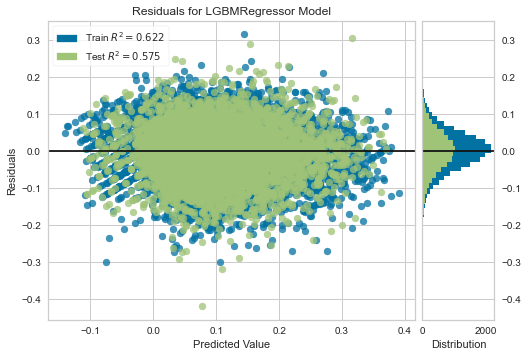

In [75]:
plot_model(lightgbm, plot = 'residuals')

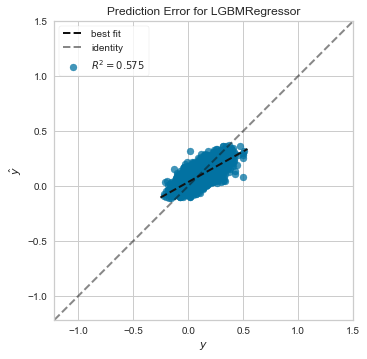

In [76]:
plot_model(lightgbm, plot = 'error')

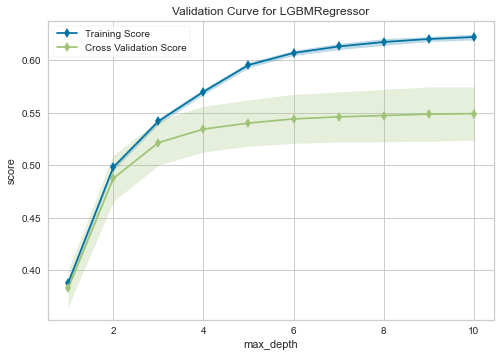

In [77]:
plot_model(lightgbm, plot='vc')

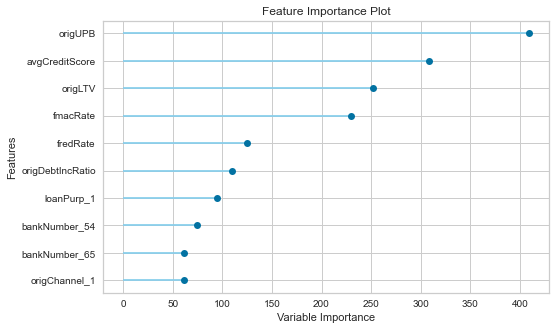

In [79]:
plot_model(lightgbm, plot = 'feature')

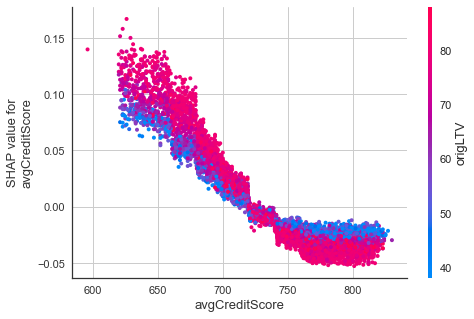

In [81]:
interpret_model(lightgbm, plot='correlation', feature='avgCreditScore')

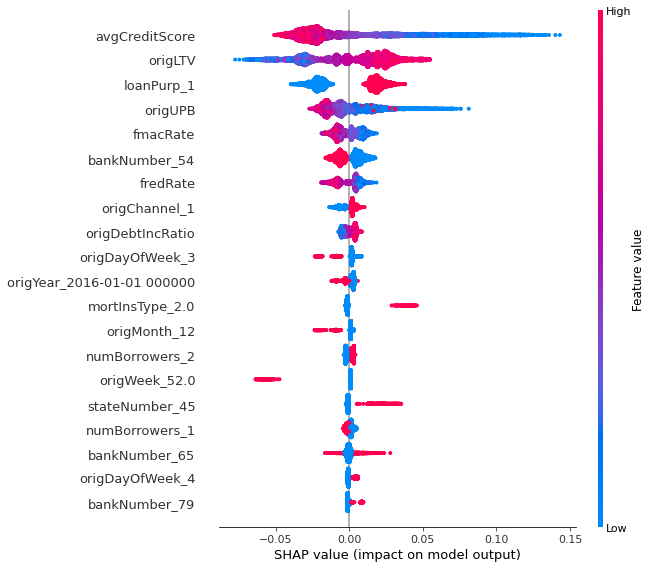

In [73]:
interpret_model(tuned_catboost)

In [ ]:
save_model()

In [ ]:
interpret_model(estimator=logreg_model, plot='reason')

In [ ]:
logreg_model2=create_model('xgboost')

In [ ]:
plot_model(estimator=logreg_model2, plot='feature')

In [ ]:
plot_model(estimator=logreg_model2)

In [ ]:
tunned_logreg_model=tune_model('catboost')

In [ ]:
interpret_model(estimator=tunned_logreg_model,plot='summary')

In [ ]:
plot_model(estimator=tunned_logreg_model,plot='feature')

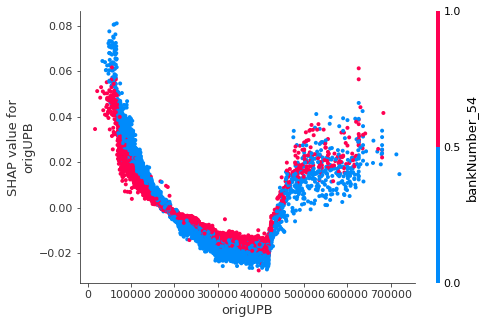

In [57]:
interpret_model(estimator=catboost, plot='correlation')

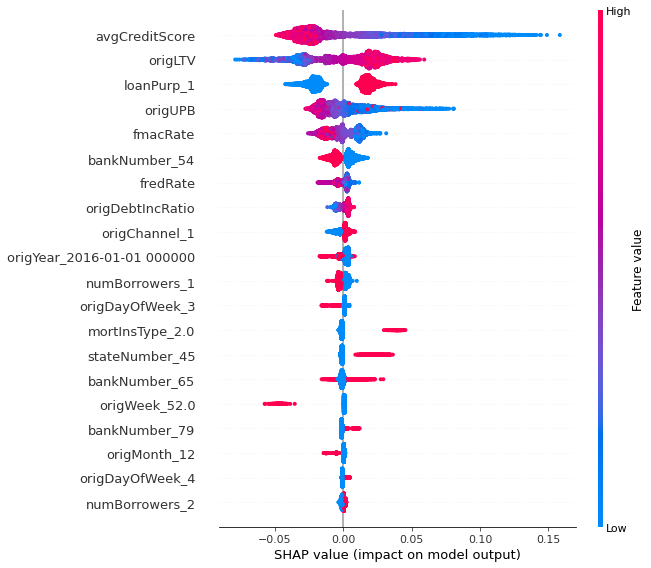

In [74]:
interpret_model(estimator=catboost,plot='summary')